In [71]:
import pandas as pd
import config
import database as db
import matplotlib.pyplot as plt
from scipy import stats

In [72]:
dfPrice = pd.read_excel('C:/Users/alexl/Dropbox/Alex/aleexv6Corporation/Trading/Data/Matif Wheat Rolling Futures.xlsx')
dfPrice = dfPrice.set_index('Date')
dfPrice

,Last Price,Open Interest
Date,,
1999-01-04,120.00,NaN
1999-01-05,119.00,2097.0
1999-01-06,117.25,2514.0
1999-01-07,117.00,2544.0
1999-01-08,117.00,2614.0
...,...,...
2024-06-27,227.25,186324.0
2024-06-28,224.75,182905.0
2024-07-01,230.25,181788.0


In [73]:
cursor = db.get_database_cot_euronext().find({})
dfCot = pd.DataFrame(list(cursor)).sort_values(by='Date', ascending=True)

In [74]:
def format_data_euronext(df):
    df = df.drop('_id', axis=1)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    percent_data_list = ["Entreprises d'investissement et établissements de crédit pourcentage position Long (Total)",
        "Entreprises d'investissement et établissements de crédit pourcentage position Short (Total)",
        "Entreprises d'investissement et établissements de crédit pourcentage position Long (Hedge)",
        "Entreprises d'investissement et établissements de crédit pourcentage position Short (Hedge)",
        "Entreprises d'investissement et établissements de crédit pourcentage position Long (Autre)",
        "Entreprises d'investissement et établissements de crédit pourcentage position Short (Autre)",
        "Fonds d'investissement pourcentage position Long (Total)",
        "Fonds d'investissement pourcentage position Short (Total)",
        "Fonds d'investissement pourcentage position Long (Hedge)",
        "Fonds d'investissement pourcentage position Short (Hedge)",
        "Fonds d'investissement pourcentage position Long (Autre)",
        "Fonds d'investissement pourcentage position Short (Autre)",
        "Autres institutions financières pourcentage position Long (Total)",
        "Autres institutions financières pourcentage position Short (Total)",
        "Autres institutions financières pourcentage position Long (Hedge)",
        "Autres institutions financières pourcentage position Short (Hedge)",
        "Autres institutions financières pourcentage position Long (Autre)",
        "Autres institutions financières pourcentage position Short (Autre)",
        "Entreprises commerciales pourcentage position Long (Total)",
        "Entreprises commerciales pourcentage position Short (Total)",
        "Entreprises commerciales pourcentage position Long (Hedge)",
        "Entreprises commerciales pourcentage position Short (Hedge)",
        "Entreprises commerciales pourcentage position Long (Autre)",
        "Entreprises commerciales pourcentage position Short (Autre)",
        "Exploitants soumis à des obligations de conformité pourcentage position Long (Totale)",
        "Exploitants soumis à des obligations de conformité pourcentage position Short (Totale)",
        "Exploitants soumis à des obligations de conformité pourcentage position Long (Hedge)",
        "Exploitants soumis à des obligations de conformité pourcentage position Short (Hedge)",
        "Exploitants soumis à des obligations de conformité pourcentage position Long (Autre)",
        "Exploitants soumis à des obligations de conformité pourcentage position Short (Autre)"]
    
    df[percent_data_list] = df[percent_data_list].apply(lambda x: x.str.strip('%'))

    df = df.drop("Autres institutions financières nombre acteurs", axis=1)
    df = df.drop("Exploitants soumis à des obligations de conformité nombre acteurs", axis=1)
    df = df.drop("Fonds d'investissement nombre acteurs", axis=1)
    df = df.drop("Entreprises d'investissement et établissements de crédit nombre acteurs", axis=1)
    df = df.drop("Entreprises commerciales nombre acteurs", axis=1)

    element = ['Produit', 'Ticker']
    elements = [col for col in df.columns if col not in element]
    df[elements] = df[elements].astype(float)

    df = df.rename(columns={"Entreprises commerciales variation Long (Totale)" : "Entreprises commerciales variation Long (Total)", "Entreprises commerciales variation Short (Totale)" : "Entreprises commerciales variation Short (Total)"})

    return df

In [75]:
dfCot = format_data_euronext(dfCot)

In [80]:
dfCotEBM = dfCot[dfCot['Ticker'] == 'EBM'].copy()
dfCotEBM = dfCotEBM.reset_index()
dfCotEBM['FundNetVar'] = dfCotEBM["Fonds d'investissement variation Long (Total)"] - dfCotEBM["Fonds d'investissement variation Short (Total)"]
dfCotEBM['Year'] = dfCotEBM['Date'].dt.year
dfCotEBM['Week'] = dfCotEBM['Date'].dt.isocalendar().week

weeklyPrice = dfPrice.resample('W').agg({
    'Last Price': 'last',
})
weeklyPrice['Change'] = weeklyPrice['Last Price'].pct_change() * 100
weeklyPrice = weeklyPrice.reset_index()
weeklyPrice['Year'] = weeklyPrice['Date'].dt.year
weeklyPrice['Week'] = weeklyPrice['Date'].dt.isocalendar().week
weeklyPrice


,Date,Last Price,Change,Year,Week
0,1999-01-10,117.00,NaN,1999,1
1,1999-01-17,113.75,-2.777778,1999,2
2,1999-01-24,113.50,-0.219780,1999,3
3,1999-01-31,116.00,2.202643,1999,4
4,1999-02-07,113.00,-2.586207,1999,5
...,...,...,...,...,...
1326,2024-06-09,243.75,-5.978785,2024,23
1327,2024-06-16,236.75,-2.871795,2024,24
1328,2024-06-23,224.50,-5.174234,2024,25
1329,2024-06-30,224.75,0.111359,2024,26


In [81]:
df = pd.merge(weeklyPrice, dfCotEBM, on=['Year', 'Week'], how='inner')

In [82]:
df[['Date_x', 'Date_y','Ticker', 'Last Price', 'Year', 'Week', 'FundNetVar', 'Change']]

,Date_x,Date_y,Ticker,Last Price,Year,Week,FundNetVar,Change
0,2018-04-22,2018-04-20,EBM,163.00,2018,16,0.0,-1.062215
1,2018-04-29,2018-04-27,EBM,166.25,2018,17,345.0,1.993865
2,2018-05-06,2018-05-04,EBM,169.50,2018,18,2579.0,1.954887
3,2018-05-13,2018-05-11,EBM,171.75,2018,19,3674.0,1.327434
4,2018-05-27,2018-05-25,EBM,182.50,2018,21,9440.0,3.253182
...,...,...,...,...,...,...,...,...
312,2024-06-02,2024-05-31,EBM,259.25,2024,22,7794.0,-0.765550
313,2024-06-09,2024-06-07,EBM,243.75,2024,23,-18407.0,-5.978785
314,2024-06-16,2024-06-14,EBM,236.75,2024,24,-13126.0,-2.871795
315,2024-06-23,2024-06-21,EBM,224.50,2024,25,-34344.0,-5.174234


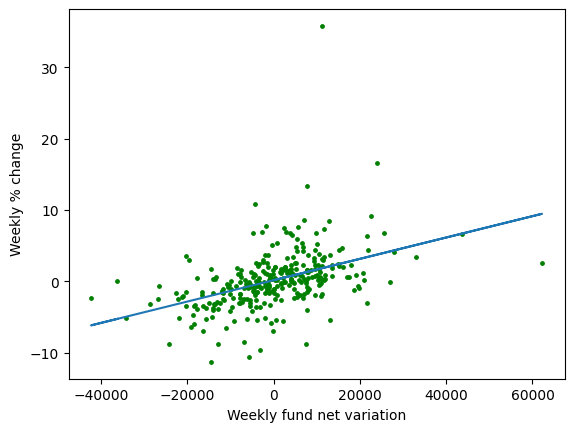

R value :  0.4405634286953929
R² value :  0.19409613470384054


In [83]:
x = df['FundNetVar']
y = df['Change']
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.scatter(x, y, color='green', s=6)
plt.xlabel('Weekly fund net variation')
plt.ylabel('Weekly % change')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()
print('R value : ', r_value)
print('R² value : ', r_value*r_value)

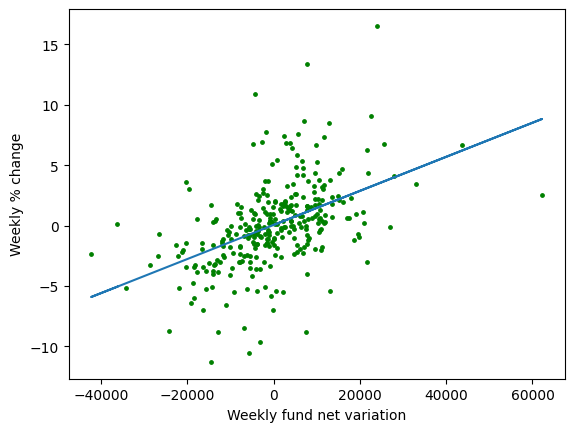

R value :  0.47753012657927657
R² value :  0.22803502179081991


In [84]:
df = df[df['Change'] < 30]
x = df['FundNetVar']
y = df['Change']
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.scatter(x, y, color='green', s=6)
plt.xlabel('Weekly fund net variation')
plt.ylabel('Weekly % change')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()
print('R value : ', r_value)
print('R² value : ', r_value*r_value)